In [1]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ Memoria GPU configurada correctamente")
    except RuntimeError as e:
        print(e)

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✓ Memoria GPU configurada correctamente


In [2]:
#1. Importar librerias

import os
import numpy as np
import pandas as pd
import cv2
from glob import glob
from tensorflow.keras import layers, models

In [3]:
#2. Rutas y parámetros globales

# Rutas principales
BASE_IMG  = r"../data/processed"
BASE_MASK = r"../data/masks_manual_bin"

# CSVs
train_df = pd.read_csv("train_split.csv")
val_df   = pd.read_csv("val_split.csv")

IMG_SIZE = (384,384)
BATCH = 4

In [4]:
#3. Funciones para cargar imágenes y máscaras
def load_image(path):
    path = path.numpy().decode("utf-8")   # ← corrección
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = img.astype(np.float32) / 255.0
    img = np.expand_dims(img, -1)
    return img

def load_mask(path):
    path = path.numpy().decode("utf-8")   # ← corrección
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    mask = (mask > 127).astype(np.float32)
    mask = np.expand_dims(mask, -1)
    return mask

def load_pair(img_path, mask_path):
    img = load_image(img_path)
    mask = load_mask(mask_path)
    return img, mask
    
def tf_wrapper(img_path, mask_path):
    img, mask = tf.py_function(
        load_pair,
        [img_path, mask_path],
        [tf.float32, tf.float32]
    )
    img.set_shape([384,384,1])
    mask.set_shape([384,384,1])
    return img, mask

In [5]:
#4. Dataset API para entrenamiento

def df_to_dataset(df, shuffle=True):
    paths_img  = df["img"].values
    paths_mask = df["mask"].values

    ds = tf.data.Dataset.from_tensor_slices((paths_img, paths_mask))
    ds = ds.map(tf_wrapper, num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(512)

    return ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
val_ds   = df_to_dataset(val_df, shuffle=False)

print(train_ds, val_ds)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float32, name=None))> <PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 384, 384, 1), dtype=tf.float32, name=None))>


In [6]:
#5. Métricas + Loss (Dice + BCE)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    return bce + (1 - dice_coef(y_true, y_pred))


In [7]:
#6. IMPLEMENTACIÓN COMPLETA DE ATTENTION U-NET

def attention_gate(x, g, inter_shape):
    # 1x1 conv para ajustar canales
    theta_x = layers.Conv2D(inter_shape, kernel_size=1, strides=1, padding='same')(x)
    phi_g = layers.Conv2D(inter_shape, kernel_size=1, strides=1, padding='same')(g)

    # Ajuste de resolución: si no coinciden, se reescala g
    if theta_x.shape[1] != phi_g.shape[1]:
        scale = theta_x.shape[1] // phi_g.shape[1]
        phi_g = layers.UpSampling2D(size=(scale, scale), interpolation='bilinear')(phi_g)

    add = layers.Add()([theta_x, phi_g])
    relu = layers.Activation('relu')(add)
    psi = layers.Conv2D(1, kernel_size=1, padding='same')(relu)
    sigmoid = layers.Activation('sigmoid')(psi)

    # Multiplicación con atención
    return layers.Multiply()([x, sigmoid])


def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    return x


def AttentionUNet(input_shape=(384,384,1)):
    inputs = layers.Input(input_shape)

    # Encoder
    c1 = conv_block(inputs, 32);  p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64);      p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128);     p3 = layers.MaxPooling2D()(c3)
    c4 = conv_block(p3, 256);     p4 = layers.MaxPooling2D()(c4)

    # Bottleneck
    bn = conv_block(p4, 512)

    # Decoder + attention gates
    # --- Level 4 ---
    g4 = layers.Conv2D(256, 1)(bn)
    a4 = attention_gate(c4, g4, 256)
    u4 = layers.UpSampling2D()(bn)
    u4 = layers.Concatenate()([u4, a4])
    d4 = conv_block(u4, 256)

    # --- Level 3 ---
    g3 = layers.Conv2D(128, 1)(d4)
    a3 = attention_gate(c3, g3, 128)
    u3 = layers.UpSampling2D()(d4)
    u3 = layers.Concatenate()([u3, a3])
    d3 = conv_block(u3, 128)

    # --- Level 2 ---
    g2 = layers.Conv2D(64, 1)(d3)
    a2 = attention_gate(c2, g2, 64)
    u2 = layers.UpSampling2D()(d3)
    u2 = layers.Concatenate()([u2, a2])
    d2 = conv_block(u2, 64)

    # --- Level 1 ---
    g1 = layers.Conv2D(32, 1)(d2)
    a1 = attention_gate(c1, g1, 32)
    u1 = layers.UpSampling2D()(d2)
    u1 = layers.Concatenate()([u1, a1])
    d1 = conv_block(u1, 32)

    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d1)

    return models.Model(inputs, outputs)

In [8]:
#7. Compilar modelo

model = AttentionUNet()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=bce_dice_loss,
              metrics=[dice_coef])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 384, 384, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 384, 384, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [9]:
#8. Entrenamiento

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        "att_unet_best.h5",
        save_best_only=True,
        monitor="val_dice_coef",
        mode="max"
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=60,
    callbacks=callbacks
)

Epoch 1/60
80/80 [==============================] - 506s 281ms/step - loss: 0.8695 - dice_coef: 0.4725 - val_loss: 1.2731 - val_dice_coef: 0.1776 - lr: 1.0000e-04
Epoch 2/60
80/80 [==============================] - 21s 249ms/step - loss: 0.6600 - dice_coef: 0.5695 - val_loss: 1.2456 - val_dice_coef: 0.1512 - lr: 1.0000e-04
Epoch 3/60
80/80 [==============================] - 21s 249ms/step - loss: 0.5870 - dice_coef: 0.6106 - val_loss: 1.2553 - val_dice_coef: 0.1323 - lr: 1.0000e-04
Epoch 4/60
80/80 [==============================] - 21s 250ms/step - loss: 0.5290 - dice_coef: 0.6438 - val_loss: 1.2712 - val_dice_coef: 0.1188 - lr: 1.0000e-04
Epoch 5/60
80/80 [==============================] - 21s 250ms/step - loss: 0.4725 - dice_coef: 0.6764 - val_loss: 1.2836 - val_dice_coef: 0.1107 - lr: 1.0000e-04
Epoch 6/60
80/80 [==============================] - 21s 250ms/step - loss: 0.4320 - dice_coef: 0.7017 - val_loss: 0.9215 - val_dice_coef: 0.3677 - lr: 1.0000e-04
Epoch 7/60
80/80 [=========

In [10]:
#9. Guardar y exportar resultados
model.save("att_unet_final.h5")

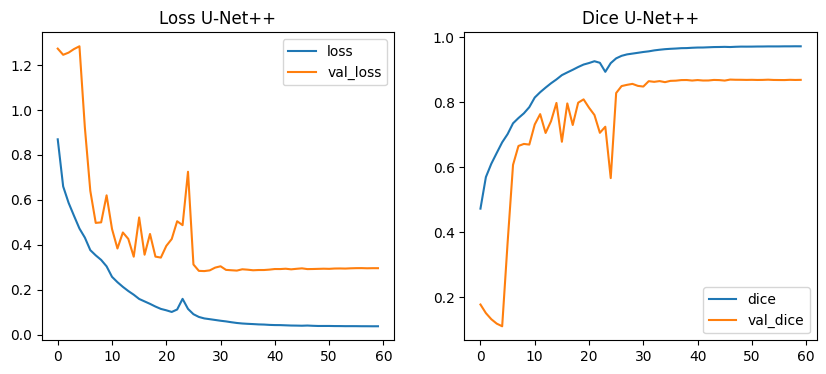

In [11]:
#10. Gráfica de métricas

import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss U-Net++")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["dice_coef"], label="dice")
plt.plot(history.history["val_dice_coef"], label="val_dice")
plt.title("Dice U-Net++")
plt.legend()

plt.show()